# Соберем отзывы по списку приложений из AppStore и GoogleStore

**Корректность проверена на:**
+ python 3.8.8
+ pandas 1.2.4
+ numpy 1.20.1

In [1]:
from app_store_scraper import AppStore
from google_play_scraper import Sort, reviews
import pandas as pd
import numpy as np

In [2]:
#прочитаем файл со списком приложений
crypto_app = pd.read_csv('cryptocurrency-related applications.csv')
crypto_app.head()

,Name,AppStore_name,AppStore_id,GoogleStore_name
0,Crypto.com,crypto-com-buy-bitcoin-eth,1262148500,co.mona.android
1,Binance,binance-buy-bitcoin-crypto,1436799971,com.binance.dev
2,KuCoin,kucoin-buy-bitcoin-ether,1378956601,com.kubi.kucoin
3,Crypto Bubbles,crypto-bubbles,1599892658,net.cryptobubbles
4,OWNR Digital Wallet,ownr-digital-wallet,1459364947,com.ownrwallet.wallet


In [3]:
#соберем по 100 отзывов по каждому приложению
df_all = pd.DataFrame()
count_all = 100 #количество отзывов по каждому приложению
for row_app in crypto_app.itertuples():
    #загрузим отзывы с AppStore
    app_store = AppStore(country='us', app_name=row_app[2], app_id = row_app[3])
    app_store.review(how_many=50)        #взяли отзывы
    df = pd.DataFrame(app_store.reviews)
    #объединим заголовок и отзыв в отзыв
    df['review'] = df['title'] + '. ' + df['review']
    #оставим только нужные колонки
    df = df.loc[:,['rating', 'review','date','userName']]
    df['app_name'] = row_app[1]   #имя приложения
    df['marketplace'] = 'Apple App Store' 
    df_all = df_all.append(df)    #добавим данные в общий фрэйм
    
    #загрузим отзывы с GooglePlay
    #определим нужное количество 
    count_for_gp = count_all - df.shape[0]
    google_play, continuation_token = reviews(row_app[4], count=count_for_gp)   #взяли отзывы
    df2 = pd.DataFrame(google_play)
    #оставим только нужные колонки
    df2 = df2.loc[:,['content', 'score','at','userName']]
    #переименуем колонки для единообразности
    df2.rename(columns = {'content':'review', 'score':'rating', 'at':'date'}, inplace = True)
    df2['app_name'] = row_app[1]   #имя приложения
    df2['marketplace'] = 'Google Play Store'
    df_all = df_all.append(df2)    #добавим данные в общий фрэйм

2023-01-23 13:14:08,078 [INFO] Base - Initialised: AppStore('us', 'crypto-com-buy-bitcoin-eth', 1262148500)
2023-01-23 13:14:08,081 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/crypto-com-buy-bitcoin-eth/id1262148500
2023-01-23 13:14:08,710 [INFO] Base - [id:1262148500] Fetched 60 reviews (60 fetched in total)
2023-01-23 13:14:08,738 [INFO] numexpr.utils - NumExpr defaulting to 8 threads.
2023-01-23 13:14:10,503 [INFO] Base - Initialised: AppStore('us', 'binance-buy-bitcoin-crypto', 1436799971)
2023-01-23 13:14:10,504 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/binance-buy-bitcoin-crypto/id1436799971
2023-01-23 13:14:11,368 [INFO] Base - [id:1436799971] Fetched 60 reviews (60 fetched in total)
2023-01-23 13:14:12,277 [INFO] Base - Initialised: AppStore('us', 'kucoin-buy-bitcoin-ether', 1378956601)
2023-01-23 13:14:12,279 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/kucoin-buy-bitcoin-ether/id1378956601

In [4]:
df_all['country'] = 'us'
df_all.rename(columns = {'review':'app_review_text', 'date':'timestamp'}, inplace = True)

In [5]:
#посмотрим, сколько всего строк и колонок
df_all.shape

(1000, 7)

In [6]:
#посмотрим,сколько в Apple App Store и Google Play Store
df_all.marketplace.value_counts()

Apple App Store      526
Google Play Store    474
Name: marketplace, dtype: int64

In [7]:
#посмотрим на собранные данные
df_all.head()

,rating,app_review_text,timestamp,userName,app_name,marketplace,country
0,4,"Great app. So far I am very new to this app, h...",2021-08-25 19:03:14,$cashguy$,Crypto.com,Apple App Store,us
1,5,Wonderful Crypto App Review Rating. I was so d...,2022-12-09 20:29:00,Joann172,Crypto.com,Apple App Store,us
2,5,Definitely sufficient wonderful app review. I ...,2023-01-13 19:40:15,Theodore$2G4,Crypto.com,Apple App Store,us
3,5,Excellent trading service app. I was so dissat...,2022-12-22 22:09:16,KayT07839$,Crypto.com,Apple App Store,us
4,5,A great crypto app 💯. I was impatient to carry...,2022-11-29 02:23:55,Maria Bronce 🍀🥰🍀,Crypto.com,Apple App Store,us


In [8]:
df_all.describe()

,rating
count,1000.000000
mean,3.735000
std,1.655753
min,1.000000
25%,2.000000
50%,5.000000
75%,5.000000
max,5.000000


In [9]:
#сохраним данные в файл
df_all.to_csv('Reviews_CryptoApp.csv',index=False)

# Посмотрим детально на собранные данные

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

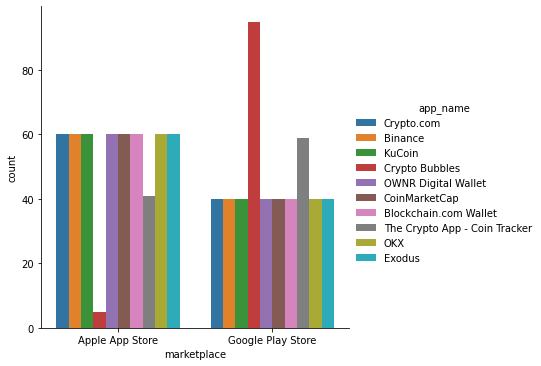

In [11]:
#сколько отзывов по каждому приложению
sns.catplot(x='marketplace', kind='count', hue='app_name', data=df_all);

In [12]:
#посмотрим на цифры
ct = pd.crosstab(df_all.app_name, df_all.marketplace, margins=True, margins_name="Total")
ct

marketplace,Apple App Store,Google Play Store,Total
app_name,,,
Binance,60,40,100
Blockchain.com Wallet,60,40,100
CoinMarketCap,60,40,100
Crypto Bubbles,5,95,100
Crypto.com,60,40,100
Exodus,60,40,100
KuCoin,60,40,100
OKX,60,40,100
OWNR Digital Wallet,60,40,100


In [13]:
#посмотрим на разброс дат таблицей
df_all["timestamp"] = df_all["timestamp"].astype("datetime64") 
df_date = df_all.copy()
df_date = df_date.drop(['rating','app_review_text','app_name','marketplace','country','userName'], axis=1)
df_date.groupby([df_date['timestamp'].dt.year,df_date['timestamp'].dt.month]).count()

timestamp
timestamp timestamp           
2017      11                 1
2018      3                  1
          5                  2
          6                  1
          10                 1
          11                 2
          12                 1
2019      2                  1
          3                  1
          4                  1
          5                  2
          6                  1
          7                  2
          9                  4
          10                 2
          11                 1
          12                 3
2020      1                  6
          2                  2
          3                  1
          5                  3
          6                  3
          7                 31
          8                  8
          9                 16
          10                19
          11                 8
          12                 6
2021      1                 12
          2                 23
          3                 16
          4                 21
          5                 30
          6                 29
          7                 10
          8                  8
          9                 21
          10                21
          11                23
          12                23
2022      1                 17
          2                 16
          3                 11
          4                 15
          5                 12
          6                 12
          7                  6
          8                 13
          9                 33
          10                37
          11                68
          12                39
2023      1                354

Text(0.5, 1.0, 'собранные отзывы по периодам')

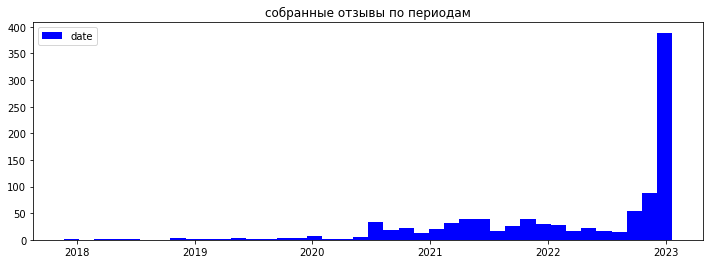

In [14]:
#посмотрим на разброс дат гистограммой
plt.figure(figsize=(12, 4))
plt.hist(df_date, bins = 40,color = 'b', label = 'date')
plt.legend()
plt.title("собранные отзывы по периодам")

In [15]:
#посмотрим на распределение рейтингов по всем отзывам
df_all.rating.value_counts()

5    562
1    216
4    105
2     62
3     55
Name: rating, dtype: int64

<AxesSubplot:title={'center':'rating all apps'}, ylabel='Frequency'>

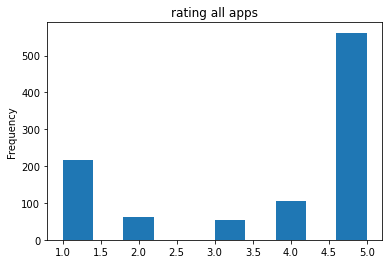

In [16]:
#посмотрим на гистограмму рейтингов по всем отзывам
df_all.rating.plot(kind='hist', title = 'rating all apps')

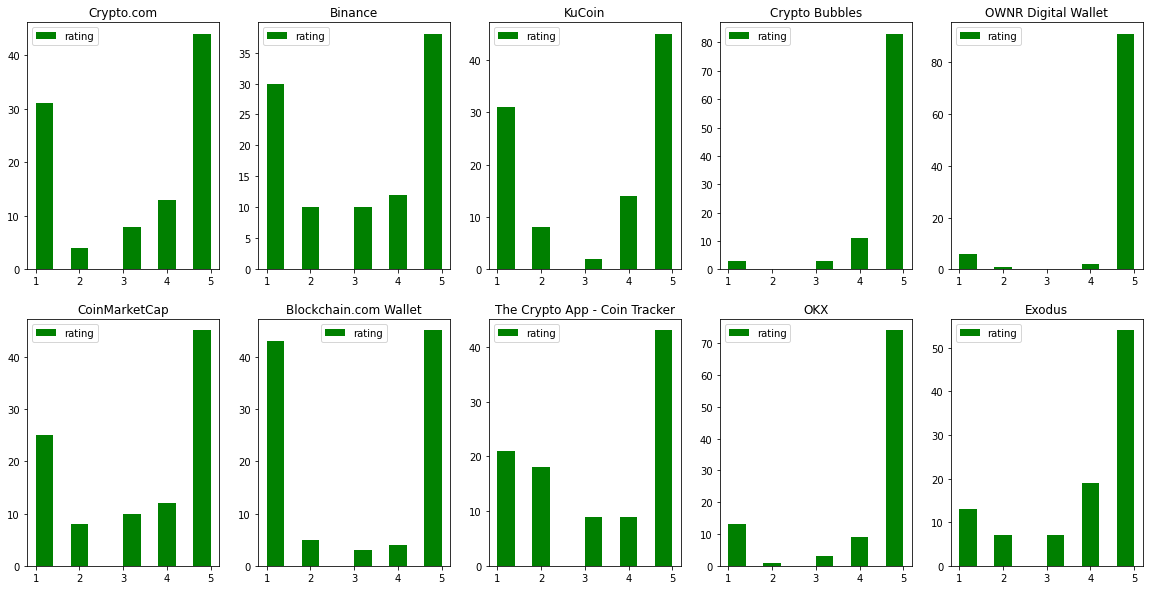

In [17]:
import math

#посмотрим на распределения рейтингов по каждому приложению
plt.figure(figsize=(20, 10))
i = 0
for row_app in crypto_app.itertuples():
    app_name = row_app[1]
    i +=1
    plt.subplot(2,5,i)
    plt.hist(df_all[df_all.app_name == app_name].rating.values, color = 'g', label = 'rating')
    plt.legend()
    plt.title(app_name)

plt.show()